# Metabolic Task Visualizer

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/docs/source/notebooks/visualizer.ipynb)

This notebook exports results for the [scCellFie Metabolic Task Visualizer](https://www.sccellfie.org). Additionally, it shows how to generate extra visualizations to summarize results.

In [1]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

We start loading an example dataset of PBMCs in Scanpy. This is the already processed data, including cell annotations.

In [3]:
adata_ref = sc.datasets.pbmc3k_processed()

In [4]:
adata_ref

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

However, we need the raw counts of all genes. So we load the raw version of it and transfer annotations from the processed dataset.

In [5]:
adata = sc.datasets.pbmc3k()

In [6]:
adata = adata[adata_ref.obs_names]
adata.obs = adata_ref.obs.copy()

In [7]:
adata

AnnData object with n_obs × n_vars = 2638 × 32738
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids'

## Run scCellFie

Now we run scCellFie on the raw data.

In [8]:
results = sccellfie.run_sccellfie_pipeline(adata, 
                                           organism='human',
                                           sccellfie_data_folder=None,
                                           n_counts_col='n_counts', 
                                           process_by_group=False, 
                                           groupby=None, 
                                           neighbors_key='neighbors',
                                           n_neighbors=10, 
                                           batch_key=None,  # Specify batch_key or leave as None
                                           threshold_key='sccellfie_threshold', 
                                           smooth_cells=True, 
                                           alpha=0.33,
                                           chunk_size=5000,
                                           disable_pbar=False, 
                                           save_folder=None,
                                           save_filename=None
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: human

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Computing neighbors ----


2025-03-23 21:09:35.158103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742764175.180383    3340 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742764175.187996    3340 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 21:09:35.221931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 22
Shape of new adata object: (2638, 900)
Number of GPRs: 783
Shape of tasks by genes: (218, 900)
Shape of reactions by genes: (783, 900)
Shape of tasks by reactions: (218, 783)

---- scCellFie Step: Smoothing gene expression ----


Smoothing Expression: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----


Cell Rxn Activities: 100%|██████████| 2638/2638 [00:13<00:00, 188.91it/s]



---- scCellFie Step: Computing metabolic task activity ----
Removed 8 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


In [9]:
results.keys()

dict_keys(['adata', 'gpr_rules', 'task_by_gene', 'rxn_by_gene', 'task_by_rxn', 'rxn_info', 'task_info', 'thresholds', 'organism'])

## Summarize results into a table to use on [scCellFie Metabolic Task Visualizer](https://www.sccellfie.org)

We want metabolic scores at a cell type level. Here, the column summarizing these groups is `'louvain'`.

In [10]:
cell_group = 'louvain'

In [11]:
report = sccellfie.reports.generate_report_from_adata(results['adata'].metabolic_tasks, cell_group, feature_name='metabolic_task')

Processing tissues: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]          


In [12]:
report.keys()

dict_keys(['agg_values', 'variance', 'std', 'threshold_cells', 'nonzero_cells', 'cell_counts', 'min_max', 'melted'])

Once we have our report data to export, we can save it with the following function in a specific output folder:

In [13]:
sccellfie.io.save_data.save_result_summary(results_dict=report, output_directory='./PBMC-Summary/')

Results saved to ./PBMC-Summary/


This function generates multiple CSV files, the ones that we need are `Melted.csv` which contains the metabolic activities per task for each of the cell types. Another useful file is the `Min_max.csv` in case we would like to explore the range of scores for each metabolic task either in a single-cell or cell-type level.

### Scale trimean using CELLxGENE reference instead of dataset itself

The `Melted.csv` file already contains a `'scaled_trimean'` column in case we would like to visualize scaled values. However, this is by using the min and max values within the dataset. In case we would like to compare it with different organs and cell types at a cell atlas level, we can use the outputs generated by using the CZI CELLxGENE atlas to scale our metabolic activities.

We start first downloading the range of min and max values in the CZI's atlas:

In [14]:
minmax = pd.read_csv('https://raw.githubusercontent.com/ventolab/sccellfie-website/refs/heads/main/data/CELLxGENEMetabolicTasksMinMax.csv', index_col=0)

In [15]:
minmax

,(R)-3-Hydroxybutanoate synthesis,3'-Phospho-5'-adenylyl sulfate synthesis,AMP salvage from adenine,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,...,Valine to succinyl-coA,Vesicle secretion,beta-Alanine degradation,beta-Alanine synthesis,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation,gamma-Linolenate synthesis,glyco-cholate synthesis,tauro-cholate synthesis
single_cell_min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
single_cell_max,7.419829,11.795217,20.651447,13.613079,4.979552,8.038148,3.030361,7.951063,1.752682,4.296328,...,6.424888,2.780753,2.980583,6.203485,2.161476,4.050148,2.341566,7.578767,2.982760,2.982760
cell_type_min,0.041299,0.000000,0.000000,0.033310,0.024252,0.023852,0.028060,0.025760,0.000000,0.021624,...,0.000000,0.000000,0.025981,0.029364,0.000000,0.013848,0.000000,0.000000,0.000000,0.000000
cell_type_max,4.403184,4.105401,5.187688,7.840590,3.159272,4.670686,1.874831,4.480565,0.854841,2.594763,...,1.313472,0.798270,1.899791,3.463882,1.151658,2.225383,1.263210,1.716187,0.941299,0.941299


We then generate a dictionary containing the cell-type level info for each of the metabolic tasks:

In [16]:
min_mapper = minmax.T['cell_type_min'].to_dict()
max_mapper = minmax.T['cell_type_max'].to_dict()

And use this information to scale the metabolic scores ('trimean' here) in our dataset.

In [17]:
melted = report['melted'].copy()
melted['min'] = melted.metabolic_task.map(min_mapper)
melted['max'] = melted.metabolic_task.map(max_mapper)

melted['scaled_trimean'] = (melted['trimean'] - melted['min']) / (melted['max'] - melted['min'])
melted['scaled_trimean'] = melted['scaled_trimean'].apply(lambda x: 0. if x < 0. else 1. if x > 1. else x)

Finally we can generate a new `Melted.csv` file that includes the scaled values with respect to the CZI CELLxGENE atlas, and use it for visualization.

In [18]:
melted.to_csv('./PBMC-Summary/Melted-ScaledCELLxGENE.csv', index=False)

## Additional visualizations

These outputs can be further used to visualize metabolic task activities with a radial plot. In this case, all cell types within the tissue are included. The maximum activity per task, across all cell types, is shown.

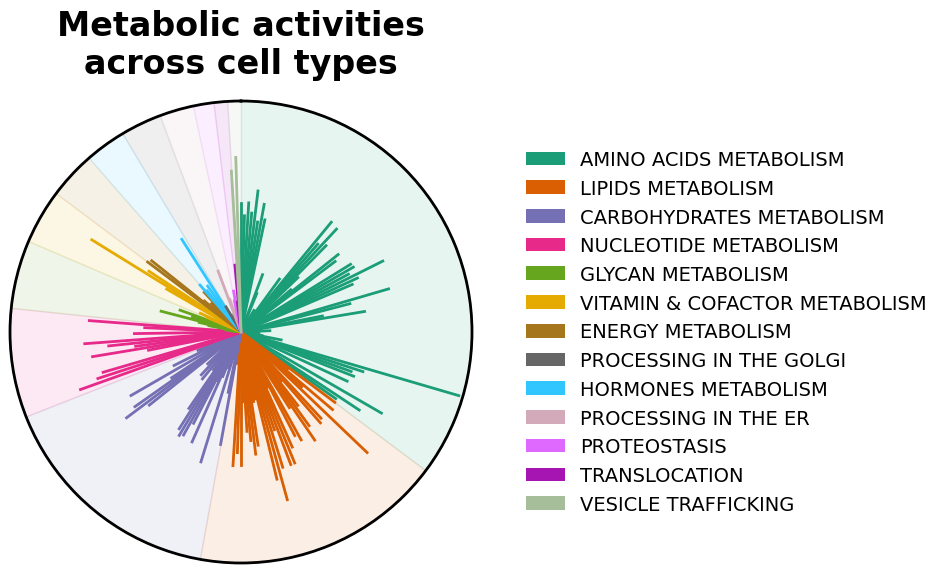

In [19]:
fig, ax = sccellfie.plotting.create_radial_plot(melted, results['task_info'], figsize=(6,6), sort_by_value=False, ylim=1.)

Or we can also plot the activities of each cell type:

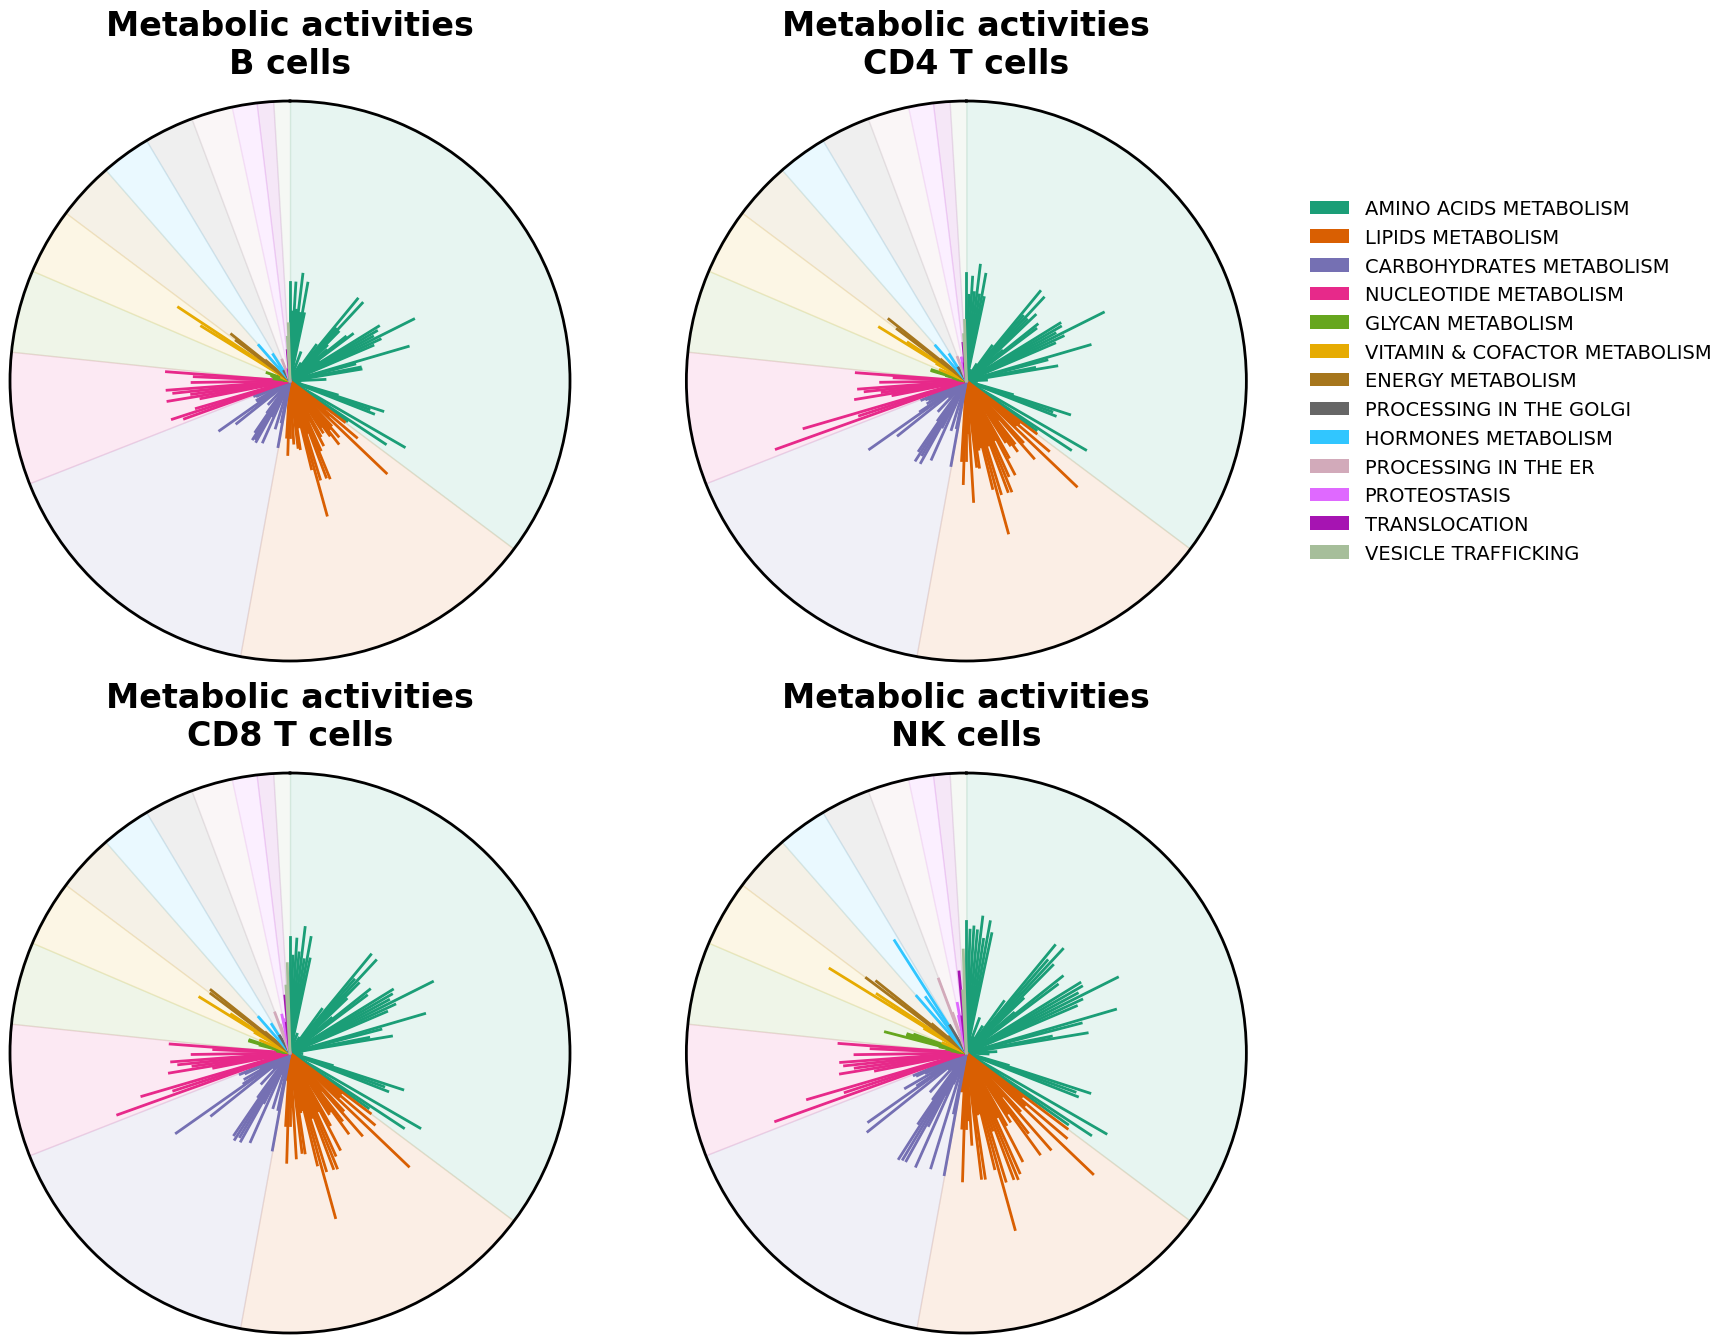

In [20]:
# Create figure with subplots
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221, projection='polar')
ax2 = fig.add_subplot(222, projection='polar')
ax3 = fig.add_subplot(223, projection='polar')
ax4 = fig.add_subplot(224, projection='polar')

for i, (cell, ax) in enumerate(zip(['B cells', 'CD4 T cells', 'CD8 T cells', 'NK cells'], [ax1, ax2, ax3, ax4])):
    sccellfie.plotting.create_radial_plot(melted, 
                                          results['task_info'],
                                          cell_type=cell,
                                          ax=ax,
                                          show_legend=i == 1,
                                          ylim=1.0
                                          )